# Court Plotting

Creating a template to plot an NBA court, can be used as a base for shot charts, etc. 

## Imports

In [200]:
%matplotlib inline
import time
import pandas as pd
import numpy as np
import requests

from functools import wraps
from io import BytesIO
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.patches import Circle, Rectangle, Arc, Wedge

from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.library.parameters import Season

player_dict = players.get_active_players()

## Plotting

In [7]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_dirs = ['/fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Inter'

In [313]:
def draw_court(ax=None, ec='#2A4644', fc='#FBE9E2', bg='#F4F5EF', lw=1.5, halfcourt=True, moreyball=False):
    """Draw an NBA court on a matplotlib axis.

    Keyword arguments:
    ec, fc, bg -- hex codes for edge (i.e. line) color, face color, and background, respectively;
    lw -- line width (default 1.5);
    halfcourt -- show / hide sidelines and halfway line (default True); and
    moreyball -- shade inside 3pt line (default False).
    """
    
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Unless it's a Moreyball plot, don't highlight the midrange with the "fc" color
    if not moreyball:
        fc = bg

    # The lines / areas are drawn in z-order, i.e. the bottom layers first and the top ones last.
    # Generally this means the filled areas are first, with the lines on top.

    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_fill_arc = Wedge((0, 0), 238.5, theta1=22.25, theta2=157.75, lw=0, fc=fc)
    three_fill_rec = Rectangle((-220.5,-47.5), 441, 137.5, lw=0, fc=fc)

    # Restricted area, 4ft radius from the center of the basket (filled with the background color)
    restricted_fill = Circle((0, 0), radius=40, lw=0, fc=bg)

    # The key - width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, lw=lw, ec=ec, fc=fc)

    # Free throw top arc, 6ft radius semi-circle from center of free throw line,
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, lw=lw, ec=ec, fill=False)
    
    # Free throw bottom arc, 6ft radius semi-circle from center of free throw line, dashed
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0, lw=lw, ec=ec, fill=False, linestyle='dashed')
    
    # Restricted Area, 4ft radius from the center of the basket
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, lw=lw, ec=ec)

    three_arc = Arc((0, 0), 477, 477, theta1=22.25, theta2=157.75, lw=lw, ec=ec)

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, lw=lw, ec=ec, fill=False)

    # Create backboard and connect to hoop
    backboard = Rectangle((-30, -11), 60, 0, lw=lw, ec=ec)
    connection = Rectangle((-1, -11), 2, 3, lw=lw, ec=ec)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_r = Rectangle((-220.5, -47.5), 0, 137.5, lw=lw, ec=ec)
    corner_three_l = Rectangle((220.5, -47.5), 0, 137.5, lw=lw, ec=ec)

    
    baseline = Rectangle((-250, -47.5), 500, 0, lw=lw, ec=ec)

    # Halfway line and sidelines
    center_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0, lw=lw, ec=ec)
    l_side = Rectangle((-250, -47.5), 0, 470, lw=lw, ec=ec)
    r_side = Rectangle((250, -47.5), 0, 470, lw=lw, ec=ec)
    halfway = Rectangle((-250, 422.5), 500, 0, lw=lw, ec=ec)

    # List of the court elements to be plotted onto the axes
    court_elements = [three_fill_arc, three_fill_rec, outer_box, top_free_throw, bottom_free_throw, 
                      corner_three_r, corner_three_l, three_arc, restricted_fill,
                      restricted, baseline, hoop, backboard, connection]
    #court_elements = [hoop, backboard, connection, outer_box, top_free_throw,
    #                  bottom_free_throw, restricted, corner_three_r,
    #                  corner_three_l, three_fill, three_arc, baseline]
    
    if halfcourt:
        court_elements.extend([center_arc, l_side, r_side, halfway])

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [159]:
# Open an image from the Internet
def open_image_online(url_address):
    response = requests.get(url_address) # Send http request to the url address
    
    # Make sure everything went right
    if response.status_code == 200:
        image_bytes = BytesIO(response.content) # Get content 
        image = Image.open(image_bytes) # Open the image
        return image # Output
    else:
        print("Failed to download image:", response.status_code)

In [132]:
# Open an image from a computer 
def open_image_local(path_to_image):
    image = Image.open(path_to_image) # Open the image
    image_array = np.array(image) # Convert to a numpy array
    return image_array # Output

In [357]:
def plot_shots(shotsDF, player_name, bg, ec, fc, percent, season):
  fig, ax = plt.subplots(figsize=(12, 12))

  # Call draw_court and pass the Axes object (ax)
  draw_court(ax=ax, moreyball=True, bg=bg, fc=fc, ec=ec)

  # Plot the shot locations, for makes and misses
  for i, edge_col in enumerate(['red', 'green']):
    marker_style = dict(fc=edge_col, ec=edge_col, s=150, alpha=0.4)
    ax.scatter(shotsDF[shotsDF.SHOT_MADE_FLAG == i].LOC_X, shotsDF[shotsDF.SHOT_MADE_FLAG == i].LOC_Y, **marker_style)

  # Set limits and hide the axes
  ax.set_xlim(300, -300)
  ax.set_ylim(-100, 500)
  fig.patch.set_facecolor(bg)
  ax.axis('off')

  # Plot titles
  plt.text(250, 460, f"NBA Moreyball Leaders {season}", size='22', weight='semibold')
  plt.text(250, 440, f"{player_name} — {percent}% Moreyball shots", size='16')

  player_id = [player['id'] for player in player_dict if player['full_name'].lower() == player_name.lower()][0]
  img_path = f'https://cdn.nba.com/headshots/nba/latest/1040x760/{player_id}.png'
  image = open_image_online(img_path)

  # Player image
  ax_image = fig.add_axes([0.72, 0.7659, 0.12, 0.12])
  ax_image.imshow(image)
  ax_image.axis('off')

  #plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
  #fig.tight_layout()
  fig.savefig('plot.png', bbox_inches='tight', pad_inches=-0.2)
  plt.show()


In [ ]:
print(Season.current_season)

## Data

In [15]:
# Retry Wrapper 
def retry(max_attempts=3, delay=30):
  def decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
      attempts = 0
      while attempts < max_attempts:
        try:
          return func(*args, **kwargs)
        except Exception as e:
          print(f"Attempt {attempts + 1} failed: {e}")
          attempts += 1
          if attempts < max_attempts:
              print(f"Retrying in {delay} seconds...")
              time.sleep(delay)
      raise Exception(f"Function {func.__name__} failed after {max_attempts} attempts")
    return wrapper
  return decorator

  
@retry(max_attempts=3, delay=30)
def get_shooting_locations(team_id=0, player_id=203999, season=season): #Defaults to Nikola Jokic
  return shotchartdetail.ShotChartDetail(
                                         team_id=team_id,
                                         player_id=player_id,
                                         season_nullable=season,
                                         context_measure_simple='FGA'
                                         ).shot_chart_detail.get_data_frame()

## Combined

In [341]:
def plot_shot_chart(player_name, season=Season.current_season, bg='#F4F5EF', ec='#2A4644', fc='#FBE9E2', percent=100):

  # Retrieve player name from player dictionary
  player_id = [player['id'] for player in player_dict if player['full_name'].lower() == player_name.lower()][0]

  shotsDF = get_shooting_locations(player_id=player_id, season=season)
  plot_shots(shotsDF, player_name, bg=bg, ec=ec, fc=fc, percent=percent, season=season)


## Final Function
Set the NBA player name and season below, and a shot chart will be generated.
Current the default season is last season using the NBA_api `season` class - but you can change to a string in the format 'YYYY-YY'.

In [ ]:
player_name = 'Sam Merrill'
plot_shot_chart(player_name, bg='#f2ead9', ec='#444444', fc='#f3ccc5', percent=97.4)

In [2]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [5]:
from CourtPlot import CourtPlot

In [ ]:
dwplot = CourtPlot('Dean Wade', bg="#e4dbcd", ec="#403126", fc="#ffbf80")

In [7]:
from datetime import datetime

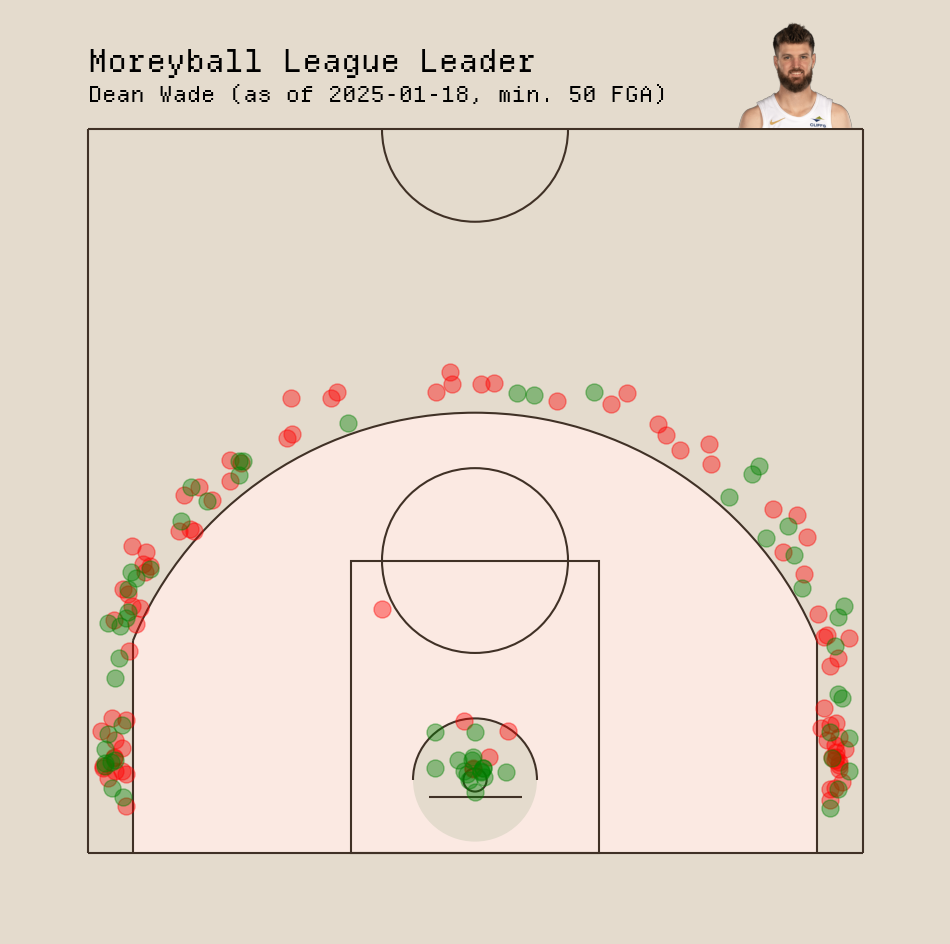

In [16]:
title_text = "Moreyball League Leader - {season}"
dwplot.plot_shots(
                    title_text="Moreyball League Leader",
                    subtitle_text = dwplot.player_name + " (as of {date}, min. 50 FGA)".format(date=datetime.today().strftime('%Y-%m-%d')),
                    save_plot=True)

# dwplot.plot_shots(subtitle_text=dwplot.player_name, title_text="Moreyball League Leader", save_plot=True)